In [1]:
from Audio import Audio
from Video import Video
from keras.models import Sequential,Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D,Conv3D,Conv1D
from keras.layers.convolutional import MaxPooling2D,MaxPooling3D,MaxPooling1D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import LSTM,Input,GlobalAveragePooling1D,Concatenate,GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint
from keras.layers.wrappers import TimeDistributed, Bidirectional
import tensorflow as tf
from keras.models import load_model
from Audio_visual import Audio_visual
#from keras.layers.extra import TimeDistributedConvolution2D, TimeDistributedMaxPooling2D, TimeDistributedFlatten

Using TensorFlow backend.


In [2]:
audio_visual = Audio_visual(path='save')
Y,classes=audio_visual.get_class()

In [3]:
trainlist=audio_visual.generate_file_list(p='train')
vallist = audio_visual.generate_file_list(p='val')
testlist = audio_visual.generate_file_list(p='test')

[INFO] loading images...
[INFO] loading images...
[INFO] loading images...


In [4]:
class_num=500

In [5]:
#inputShape = (29,120,120,3)
input1 = Input(shape = (29,120,120,3))

conv3d = Conv3D(64,(5,7,7),padding = 'same',
                strides = (1,2,2), activation='relu')(input1)
batch_norm1 = BatchNormalization()(conv3d)
maxpool3d = MaxPooling3D(pool_size=(1,2,2),padding='same')(batch_norm1)
drop1 = Dropout(0.1)(maxpool3d)

time_conv2d = TimeDistributed(Conv2D(128,(3,3),activation = 'relu'))(drop1)
batch_norm2 = BatchNormalization()(time_conv2d)
time_maxpool2d = TimeDistributed(MaxPooling2D(2,2))(batch_norm2)
drop2 = Dropout(0.1)(time_maxpool2d)

time_conv2d = TimeDistributed(Conv2D(256,(3,3),activation = 'relu'))(drop2)
batch_norm2 = BatchNormalization()(time_conv2d)
time_maxpool2d = TimeDistributed(MaxPooling2D(2,2))(batch_norm2)
drop2 = Dropout(0.1)(time_maxpool2d)

time_conv2d = TimeDistributed(Conv2D(512,(3,3),activation = 'relu'))(drop2)
batch_norm3 = BatchNormalization()(time_conv2d)
time_maxpool2d = TimeDistributed(MaxPooling2D(2,2))(batch_norm3)
drop3 = Dropout(0.1)(time_maxpool2d)

time_flatten = TimeDistributed(GlobalAveragePooling2D())(time_maxpool2d)

bilstm1 = Bidirectional(LSTM(256,return_sequences=True,dropout=0.1,
                            name='bilstm'))(time_flatten)
#bilstm2 = Bidirectional(LSTM(128,return_sequences=True))(bilstm1)

avg = GlobalAveragePooling1D(name='avg')(bilstm1)
dense1 = Dense(512,activation='relu')(avg)
batch_norm4 = BatchNormalization()(dense1)
dense2 = Dense(class_num,activation = 'softmax')(batch_norm4)

video_model = Model(inputs=[input1], 
              outputs=[dense2])

In [6]:
video_model.load_weights('video_weights/weights-improvement-08-0.68.hdf5')
video_model.trainable=False

In [7]:
input_audio = Input(shape = (26,121))

conv1d_1 = Conv1D(64,kernel_size = 3,strides=1, padding = 'same',
               activation = 'relu')(input_audio)

batch_norm1 = BatchNormalization()(conv1d_1)

batch_norm1 = MaxPooling1D(pool_size=2,padding = 'same')(batch_norm1)

conv1d_2 = Conv1D(128,kernel_size = 3, strides = 1, padding = 'same',
               activation = 'relu')(batch_norm1)

batch_norm2 = BatchNormalization()(conv1d_2)
batch_norm2 = MaxPooling1D(pool_size=2,padding = 'same')(batch_norm2)

conv1d_2 = Conv1D(512,kernel_size = 3, strides = 1, padding = 'same',
               activation = 'relu')(batch_norm2)

batch_norm2 = BatchNormalization()(conv1d_2)
batch_norm2 = MaxPooling1D(pool_size=2,padding = 'same')(batch_norm2)

bilstm1 = Bidirectional(LSTM(256,return_sequences=True,name='bilstm1'))(batch_norm2)
#bilstm2 = Bidirectional(LSTM(256,return_sequences=True),name = 'bilstm2')(bilstm1)

avgpool = GlobalAveragePooling1D(name='audio_avg')(bilstm1)

dense1 = Dense(512,activation='relu')(avgpool)
batch_norm3 = BatchNormalization()(dense1)
dense2 = Dense(class_num,activation = 'softmax')(batch_norm3)

audio_model = Model(inputs=[input_audio], 
              outputs=[dense2])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [8]:
audio_model.load_weights('audio_weights/first-improvement-11-0.82.hdf5')
audio_model.trainable=False
audio_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 26, 121)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 64)            23296     
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 128)           24704     
_________________________________________________________________
batch_normalization_7 (Batch (None, 13, 128)           512       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 128)            0         
__________

In [9]:
class_num=500
video_result = video_model.get_layer('avg').output
audio_result = audio_model.get_layer('audio_avg').output

concatenate = Concatenate()([video_result,audio_result])

dense1 = Dense(512,activation='relu')(concatenate)
batchnorm = BatchNormalization()(dense1)
output=Dense(class_num,activation='softmax')(batchnorm)


In [10]:
model = Model(inputs=[video_model.input,audio_model.input], 
              outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 29, 120, 120, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 29, 60, 60, 6 47104       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 29, 60, 60, 6 256         conv3d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)  (None, 29, 30, 30, 6 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

In [11]:
print("[INFO] compiling model...")
sgd = SGD(lr=0.005, decay=1e-6, momentum=0.9)
#adam = Adam(lr = 0.003,decay=1e-6)
model.compile(loss="categorical_crossentropy", optimizer=sgd,
	metrics=["accuracy"])

[INFO] compiling model...


In [12]:
from keras.callbacks import EarlyStopping

In [13]:
print("[INFO] training network...")
sample_number = len(trainlist)
val_number = len(vallist)
#print(sample_number)
filepath="weights/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,
mode='max')
stopper = EarlyStopping(monitor='val_acc',patience=3)
callbacks_list = [checkpoint,stopper]

history = model.fit_generator(audio_visual.generate_array(trainlist,batch_size=48),
                        validation_data=
                    audio_visual.generate_array(vallist,batch_size=48),
                        steps_per_epoch=sample_number // 48,
                    validation_steps = val_number//48,
                        epochs=8, verbose=1,
                   callbacks = callbacks_list)

[INFO] training network...
Epoch 1/8
10182/10182 [==============================] - 70992s 7s/step - loss: 0.4398 - acc: 0.9026 - val_loss: 0.2795 - val_acc: 0.9195

Epoch 00001: val_acc improved from -inf to 0.91947, saving model to weights/weights-improvement-01-0.92.hdf5
Epoch 2/8
10182/10182 [==============================] - 66633s 7s/step - loss: 0.0996 - acc: 0.9739 - val_loss: 0.2592 - val_acc: 0.9252

Epoch 00002: val_acc improved from 0.91947 to 0.92520, saving model to weights/weights-improvement-02-0.93.hdf5
Epoch 3/8
10182/10182 [==============================] - 61873s 6s/step - loss: 0.0597 - acc: 0.9848 - val_loss: 0.2554 - val_acc: 0.9274

Epoch 00003: val_acc improved from 0.92520 to 0.92736, saving model to weights/weights-improvement-03-0.93.hdf5
Epoch 4/8
10182/10182 [==============================] - 60057s 6s/step - loss: 0.0393 - acc: 0.9909 - val_loss: 0.2492 - val_acc: 0.9290

Epoch 00004: val_acc improved from 0.92736 to 0.92905, saving model to weights/weigh

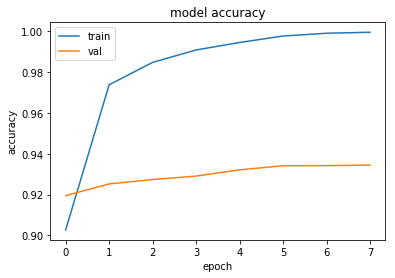

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.savefig('audiovisualacc.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.savefig('audiovisualloss.png')
plt.show()


In [15]:
model.evaluate_generator(audio_visual.generate_array(testlist,batch_size=48),
                         steps=len(testlist)//48)

NameError: name 'video' is not defined